# That last one

We are not gonna do a lot of new things today. Mostly we'll just combine what you have learned in order to make our final prediction. It is important that you have successfully run week12split.ipynb (in geo_env) before starting on this exercises (in xgb_env). The reason is that we a going to use the pickles generated in week12split.ipynb Lets get to it.

In [67]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import cm
import seaborn as sns # install with conda install seaborn in xgb_env

import pickle
import time

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [36]:
pkl_file = open('y_train_week12.pkl', 'rb')
y_train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('X_train_week12.pkl', 'rb')
X_train = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('y_val_week12.pkl', 'rb')
y_val = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('X_val_week12.pkl', 'rb')
X_val = pickle.load(pkl_file)
pkl_file.close()

In [37]:
print(y_train.shape)
print(X_train.shape)
print(y_val.shape)
print(X_val.shape)

(1555632, 5)
(1555632, 56)
(64818, 5)
(64818, 56)


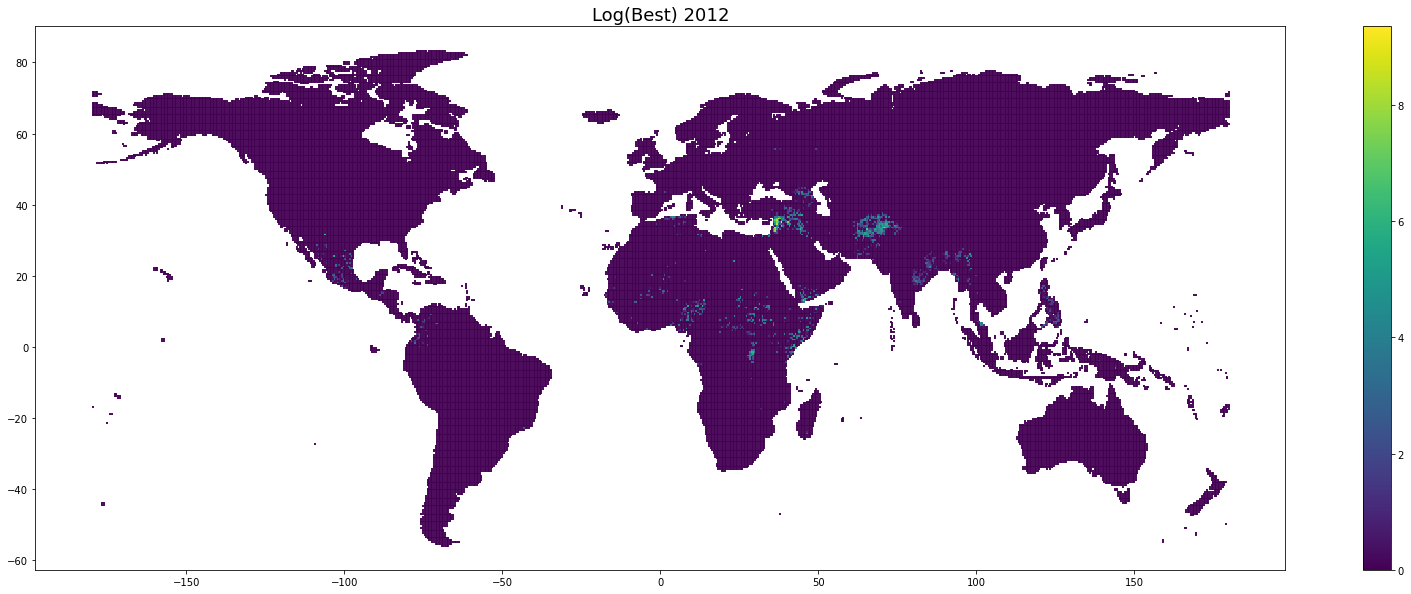

In [38]:
plt.figure(figsize = [28,10])
plt.title('Log(Best) 2012', fontsize = 18)
plt.scatter(X_train[X_train['year'] == 2012]['xcoord'], X_train[X_train['year'] == 2012]['ycoord'], c = X_train[X_train['year'] == 2012]['log_best'], s=1, marker='s')
plt.colorbar()
plt.show()

In [39]:
model = XGBClassifier(n_estimators=16, random_state = 42)# 16 estimators is very low. Try 32, 64 or 128 if you have the time
model.fit(X_train, y_train['binary_best_t1'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=16, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
y_train_pred = model.predict_proba(X_train)[:,1]
y_val_pred = model.predict_proba(X_val)[:,1]

In [41]:
AUC_train = metrics.roc_auc_score(y_train['binary_best_t1'], y_train_pred)
AP_train = metrics.average_precision_score(y_train['binary_best_t1'], y_train_pred)
BS_train = metrics.brier_score_loss(y_train['binary_best_t1'], y_train_pred)

AUC_val = metrics.roc_auc_score(y_val['binary_best_t1'], y_val_pred)
AP_val = metrics.average_precision_score(y_val['binary_best_t1'], y_val_pred)
BS_val = metrics.brier_score_loss(y_val['binary_best_t1'], y_val_pred)

print(f'\tTrain\tVal\nAUC: \t{AUC_train:.3f}\t{AUC_val:.3f}\nAP: \t{AP_train:.3f}\t{AP_val:.3f}\nBS: \t{BS_train:.3f}\t{BS_val:.3f}')

	Train	Val
AUC: 	0.994	0.970
AP: 	0.736	0.643
BS: 	0.006	0.010


In [42]:
grid = X_train[X_train['year'] == 2012 ][['xcoord','ycoord']].copy()# does not matter wich year you take as long as you only pick one

In [43]:
grid['predected_probs_1t'] = model.predict_proba(X_val)[:,1] 

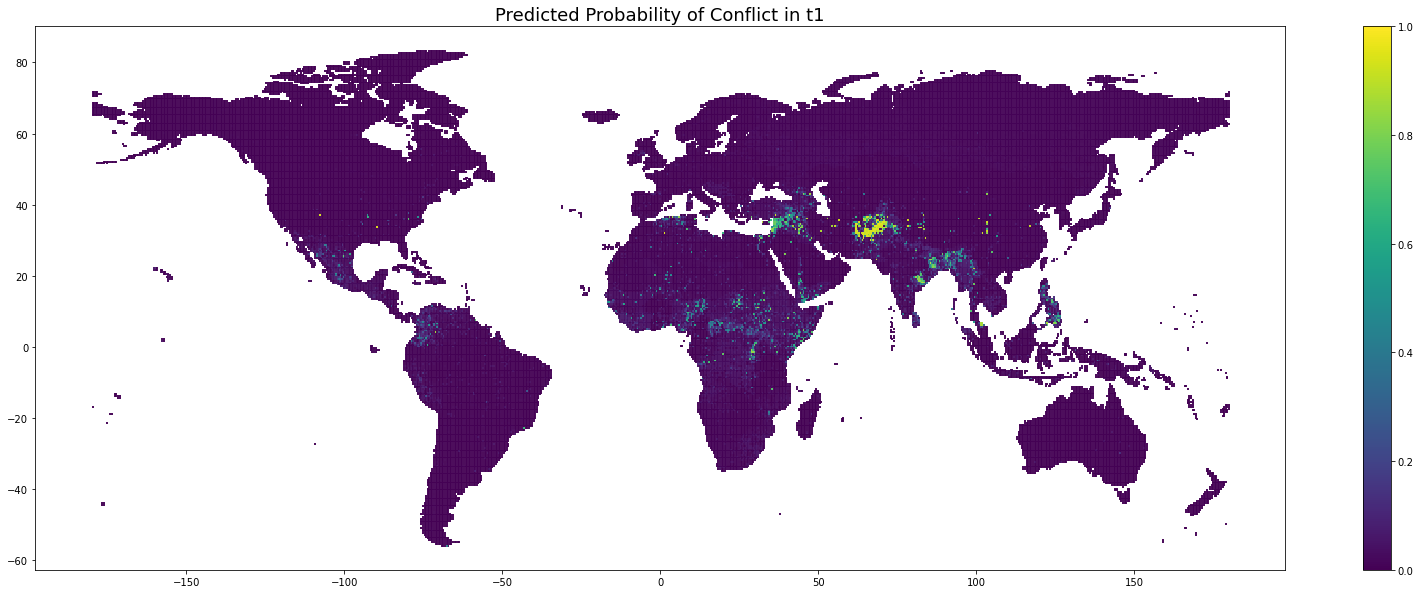

In [44]:
plt.figure(figsize = [28,10])
plt.title('Predicted Probability of Conflict in t1', fontsize = 18)
plt.scatter(grid['xcoord'], grid['ycoord'], c = grid['predected_probs_1t'], s=1, marker='s', vmin = 0, vmax =1)
plt.colorbar()
plt.show()

We make our own Ensamble - nothing fancy

In [48]:
n_rounds = 1000

n_estimators_list = []
max_depth_list = []
gamma_list = []
reg_lambda_list = []

preds = []

AP_list = []
pr_list = []

for i in range(n_rounds):

    n_estimators = np.random.randint(8,32)
    max_depth = np.random.randint(2,6)
    gamma = np.random.uniform(0.1, 1)
    reg_lambda = np.random.uniform(0.1, 0.5)
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth, gamma = gamma, reg_lambda = reg_lambda, random_state = i)
    
    model.fit(X_train, y_train['binary_best_t1'])
    y_pred = model.predict_proba(X_val)[:,1]
    
    AP = metrics.average_precision_score(y_val['binary_best_t1'], y_pred)
    precision_val, recall_val, _ = metrics.precision_recall_curve(y_val['binary_best_t1'], y_pred) 
    
    
    n_estimators_list.append(n_estimators)
    max_depth_list.append(max_depth)
    gamma_list.append(gamma)
    reg_lambda_list.append(reg_lambda)
    
    preds.append(y_pred)
    
    AP_list.append(AP)
    pr_list.append((precision_val, recall_val))

    print(f'{i+1}/{n_rounds} done', end = '\r')
    

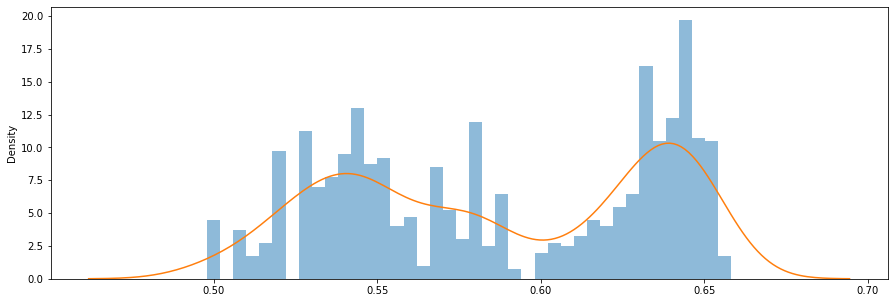

In [111]:
plt.figure(figsize = [15,5])
plt.hist(AP_list, bins = 40, density=True, alpha = 0.5)
sns.kdeplot(AP_list)
plt.show()

Alright; so this distribution is not approximate normal. It is bimodal (maybe consisting of two normals). So it seems that some sets of hyper parameters do much better the others. This undersocres the importance of not always assuming normality - at least not when we can actually test it. Lest look at what hyper paremeters helped us achive high AP:

In [127]:
hp_df = pd.DataFrame({'n_estimators' : n_estimators_list, 'max_depth' : max_depth_list, 'gamma' : gamma_list, 'lambda' : reg_lambda_list, 'preds' : preds, 'AP' : AP_list})

# just in case
file_name = "hp_df.pkl"
output = open(file_name, 'wb')
pickle.dump(hp_df, output)
output.close()

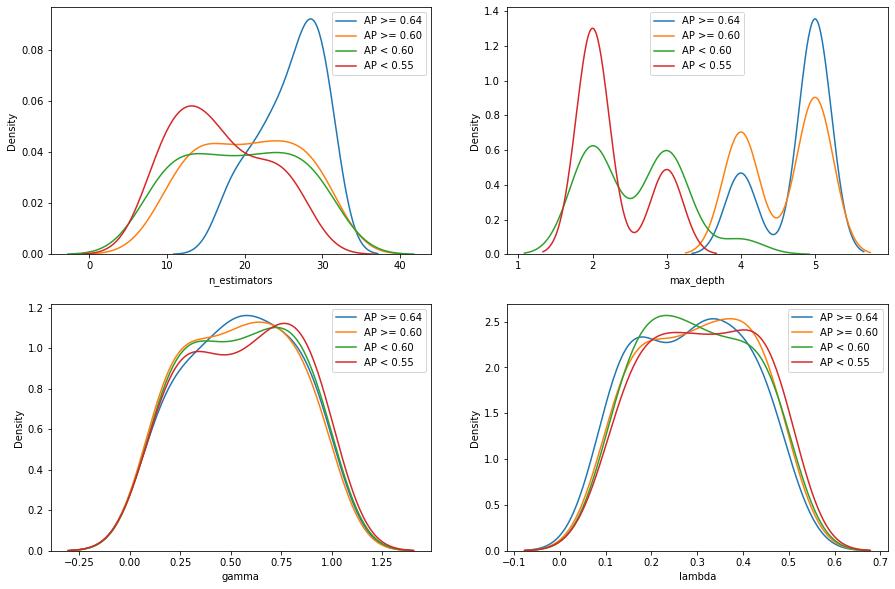

In [113]:
#plt.hist would work fine and perhaps be more "correct" - but it would not look as good ;)

plt.figure(figsize = [15,10])

for i,j in enumerate(hp_df.columns[:4]):
    plt.subplot(2,2,i+1)

    sns.kdeplot(hp_df[hp_df['AP'] >= 0.64][j], label = 'AP >= 0.64', bw_method= 0.5) # bw_method determines how 'flexible' the kde line is..
    sns.kdeplot(hp_df[hp_df['AP'] >= 0.60][j], label = 'AP >= 0.60', bw_method= 0.5)
    sns.kdeplot(hp_df[hp_df['AP'] < 0.60][j], label = 'AP < 0.60', bw_method= 0.5)
    sns.kdeplot(hp_df[hp_df['AP'] < 0.55][j], label = 'AP < 0.55', bw_method= 0.5)


    plt.legend()

plt.show()

Så we could now jusst sort out all the models with "bad" hyper parameters, but lest try to run a new batch with better params (given our new knowledge). NOte that these plots only shows ceteris paribus changes which might be somewhat imprudent. But here it still gives us some clues: Gamma and lambda does not appear to matter that much at the given values. However more estimators and deeper tress seems good. Indeed we can see that no model with less then 10 tress achived an AP above 0.64 and most had close to the difined max of 32 tress. Looking at max_depth no model with max_depth below 4 achived an AP over 0.64. And most models achiveing such high AP had the max depth of 5. So if we do one more grid search we should probably allow you search to go beyound the defined max for n_estimators and max_depth. We can also widen the range of gamme and lambda to see if we can catch something interesting. This I do below (naturally  I knew in advanced that the n_estimators was to low. I did it to save time. As such the loop below will take considerably longer to run). Lets see iff we find out something new, or at least get a unimodal, approximate normal, distirbution of results.

In [114]:
n_rounds = 1000

n_estimators_list1 = []
max_depth_list1 = []
gamma_list1 = []
reg_lambda_list1 = []

preds1 = []

AP_list1 = []
pr_list1 = []

for i in range(n_rounds):

    n_estimators = np.random.randint(32,64)# higher seemed better
    max_depth = np.random.randint(5,10) # higher seemed better
    gamma = np.random.uniform(0.1, 2) # lest just try a wider range and see if it changes anything
    reg_lambda = np.random.uniform(0.1, 1)# lest just try a wider range and see if it changes anything
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth, gamma = gamma, reg_lambda = reg_lambda, random_state = i)
    
    model.fit(X_train, y_train['binary_best_t1'])
    y_pred = model.predict_proba(X_val)[:,1]
    
    AP = metrics.average_precision_score(y_val['binary_best_t1'], y_pred)
    precision_val, recall_val, _ = metrics.precision_recall_curve(y_val['binary_best_t1'], y_pred) 
    
    
    n_estimators_list1.append(n_estimators)
    max_depth_list1.append(max_depth)
    gamma_list1.append(gamma)
    reg_lambda_list1.append(reg_lambda)
    
    preds1.append(y_pred)
    
    AP_list1.append(AP)
    pr_list1.append((precision_val, recall_val))

    print(f'{i+1}/{n_rounds} done', end = '\r')
    

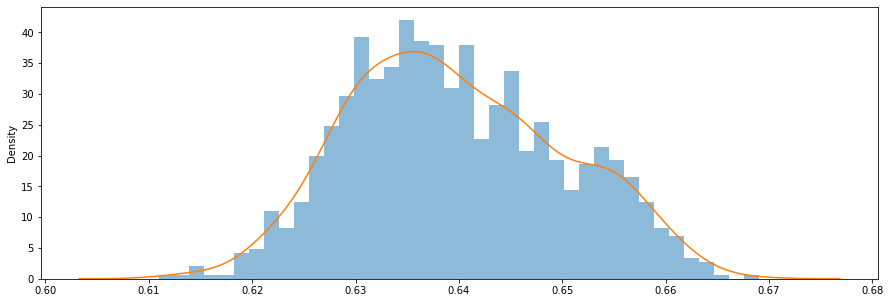

In [115]:
plt.figure(figsize = [15,5])
plt.hist(AP_list1, bins = 40, density=True, alpha = 0.5)
sns.kdeplot(AP_list1)
plt.show()

So this is more like it - thou it is still skewed. Lets look into it

In [128]:
hp_df1 = pd.DataFrame({'n_estimators' : n_estimators_list1, 'max_depth' : max_depth_list1, 'gamma' : gamma_list1, 'lambda' : reg_lambda_list1, 'preds' : preds1, 'AP' : AP_list1})

# just in case
file_name = "hp_df1.pkl"
output = open(file_name, 'wb')
pickle.dump(hp_df1, output)
output.close()

/home/polichinel/anaconda3/envs/xgb_env/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


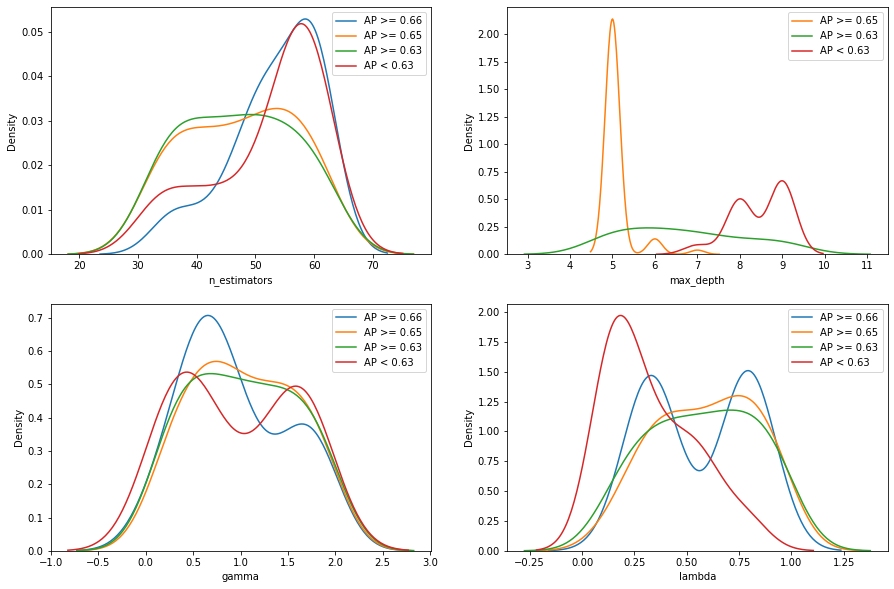

In [131]:
#plt.hist would work fine and perhaps be more "correct" - but it would not look as good ;)

plt.figure(figsize = [15,10])

for i,j in enumerate(hp_df1.columns[:4]):
    plt.subplot(2,2,i+1)
    
    sns.kdeplot(hp_df1[hp_df1['AP'] >= 0.66][j], label = 'AP >= 0.66', bw_method= 0.5)
    sns.kdeplot(hp_df1[hp_df1['AP'] >= 0.65][j], label = 'AP >= 0.65', bw_method= 0.5)
    sns.kdeplot(hp_df1[hp_df1['AP'] >= 0.63][j], label = 'AP >= 0.63', bw_method= 0.5)
    sns.kdeplot(hp_df1[hp_df1['AP'] < 0.62][j], label = 'AP < 0.63', bw_method= 0.5)

    plt.legend()

plt.show()
# Don't mind the error test. It it just du to all observation with ap over 0.66 in he second plot has the same value: max_depth = 5

In [214]:
n_rounds = 250

n_estimators_list2 = []
max_depth_list2 = []
gamma_list2 = []
reg_lambda_list2 = []

learning_rate_list2 = []
min_child_weight_list2 = []
colsample_bytree_list2 = []

preds2 = []

AP_list2 = []
pr_list2 = []

for i in range(n_rounds):

    n_estimators = 128 # higher seemed better. We just fix it now.
    
    learning_rate = np.random.uniform(0.05, 0.3)
    min_child_weight = np.random.randint(1,8)
    colsample_bytree = np.random.uniform(0.3, 0.7)
    
    max_depth = np.random.randint(4,7) # higher seemed better
    gamma = np.random.uniform(0.1, 2) # lest just try a wider range and see if it changes anything
    reg_lambda = np.random.uniform(0.25, 1)# lest just try a wider range and see if it changes anything
    
    model = XGBClassifier(n_estimators=n_estimators, max_depth = max_depth, gamma = gamma, 
                          reg_lambda = reg_lambda, learning_rate = learning_rate, min_child_weight = min_child_weight,
                          colsample_bytree = colsample_bytree, random_state = i)
    
    model.fit(X_train, y_train['binary_best_t1'])
    y_pred = model.predict_proba(X_val)[:,1]
    
    AP = metrics.average_precision_score(y_val['binary_best_t1'], y_pred)
    precision_val, recall_val, _ = metrics.precision_recall_curve(y_val['binary_best_t1'], y_pred) 
    
    n_estimators_list2.append(n_estimators)
    max_depth_list2.append(max_depth)
    gamma_list2.append(gamma)
    reg_lambda_list2.append(reg_lambda)
    
    learning_rate_list2.append(learning_rate)
    min_child_weight_list2.append(min_child_weight)
    colsample_bytree_list2.append(colsample_bytree)
    
    preds2.append(y_pred)
    
    AP_list2.append(AP)
    pr_list2.append((precision_val, recall_val))

    print(f'{i+1}/{n_rounds} done', end = '\r')
    

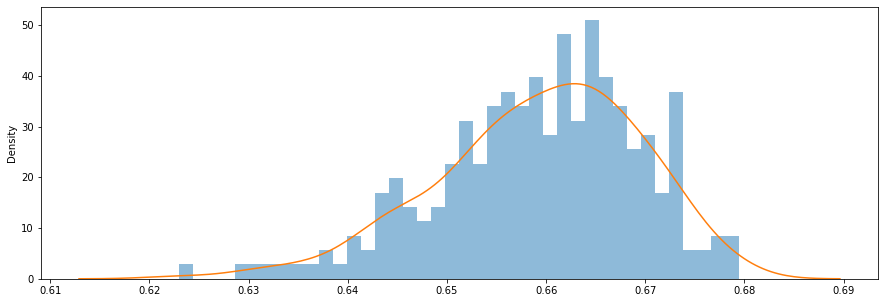

In [215]:
plt.figure(figsize = [15,5])
plt.hist(AP_list2, bins = 40, density=True, alpha = 0.5)
sns.kdeplot(AP_list2)
plt.show()

So it is still skewed, but now to the "good" side

In [216]:
hp_df2 = pd.DataFrame({'n_estimators' : n_estimators_list2, 'max_depth' : max_depth_list2, 'gamma' : gamma_list2, 'lambda' : reg_lambda_list2,
                       'learning_rate' : learning_rate_list2, 'min_child_weight' : min_child_weight_list2, 'colsample_bytree' : colsample_bytree_list2,
                       'preds' : preds2, 'AP' : AP_list2})

# just in case
file_name = "hp_df2.pkl"
output = open(file_name, 'wb')
pickle.dump(hp_df2, output)
output.close()

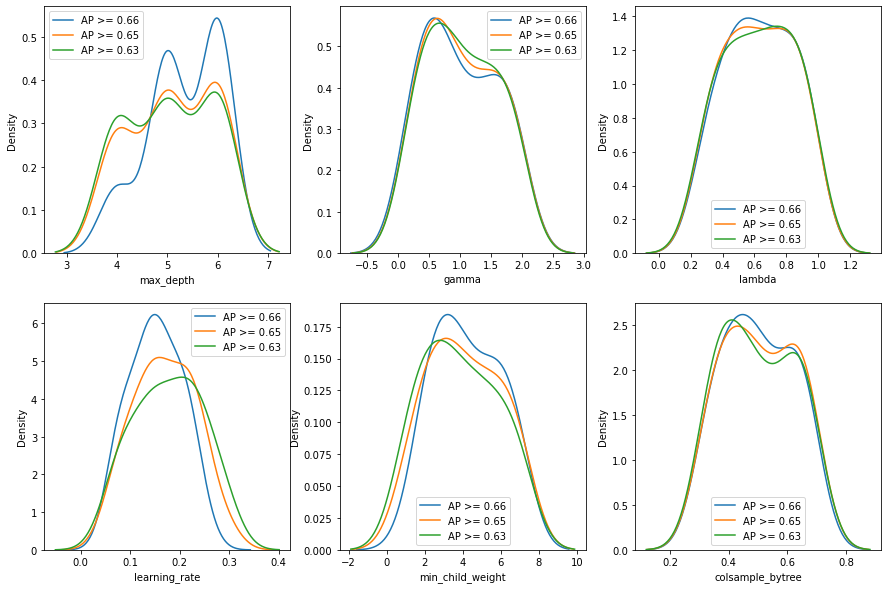

In [217]:
#plt.hist would work fine and perhaps be more "correct" - but it would not look as good ;)

plt.figure(figsize = [15,10])

for i,j in enumerate(hp_df2.columns[1:7]):
    plt.subplot(2,3,i+1)
    
    sns.kdeplot(hp_df2[hp_df2['AP'] >= 0.66][j], label = 'AP >= 0.66', bw_method= 0.5)
    sns.kdeplot(hp_df2[hp_df2['AP'] >= 0.65][j], label = 'AP >= 0.65', bw_method= 0.5)
    sns.kdeplot(hp_df2[hp_df2['AP'] >= 0.63][j], label = 'AP >= 0.63', bw_method= 0.5)
    sns.kdeplot(hp_df2[hp_df2['AP'] < 0.62][j], label = 'AP < 0.63', bw_method= 0.5)

    plt.legend()

plt.show()
# Don't mind the error test. It it just du to all observation with ap over 0.66 in he second plot has the same value: max_depth = 5

So maybe max_depth of 5 and 6 appears a bit better then 4, but over all it all seems pretty balanced

Lets create out mean preidctions and the standart diviation of these predictions:

In [218]:
grid['ensample_mean_t1'] = np.array(hp_df2['preds']).mean(axis = 0)
grid['ensample_std_t1'] = np.array(hp_df2 ['preds']).std(axis = 0)

Plot the mean predictions

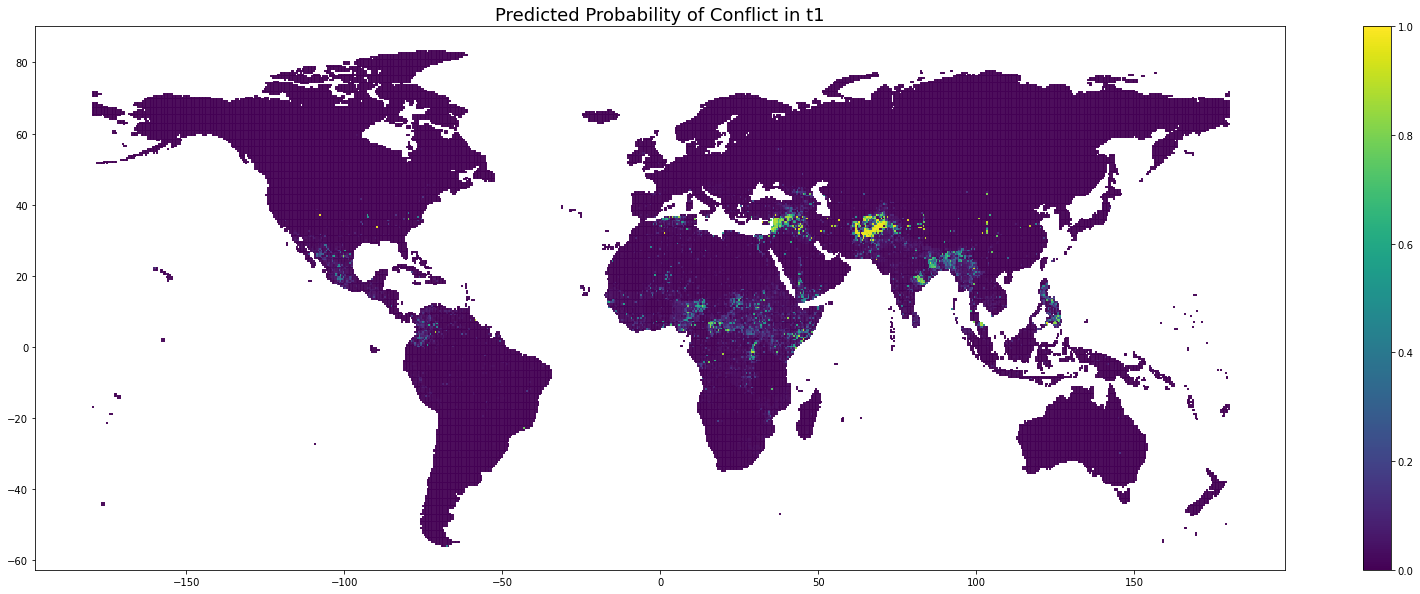

In [219]:
plt.figure(figsize = [28,10])
plt.title('Predicted Probability of Conflict in t1', fontsize = 18)
plt.scatter(grid['xcoord'], grid['ycoord'], c = grid['ensample_mean_t1'], s=1, marker='s', vmin = 0, vmax = 1)
plt.colorbar()
plt.show()

Plot the standart diviation. This is a somewhat overlooked thing to do, but super nice whan working with ensampels. It illustrates the uncertainty given by the fact that we do not know exactly how our model should be specified. This is called "model uncertainty". It is Good to know where you are certain - given our model - and where ou are not.

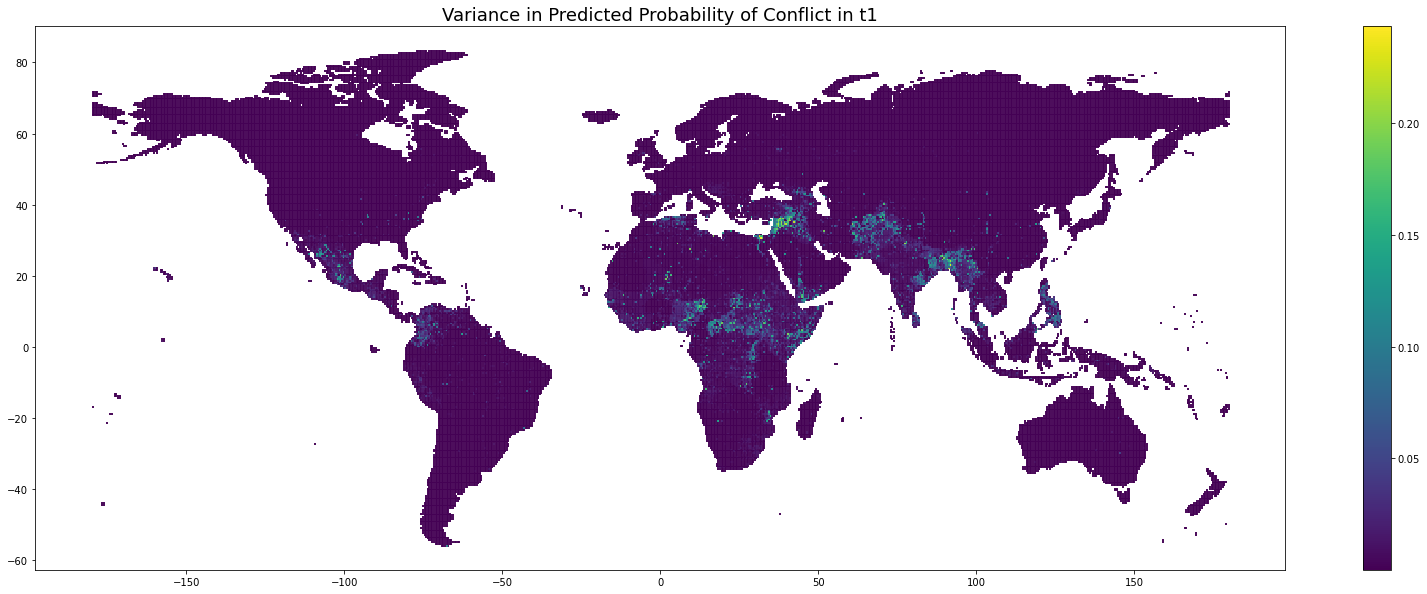

In [281]:
plt.figure(figsize = [28,10])
plt.title('Variance in Predicted Probability of Conflict in t1', fontsize = 18)
plt.scatter(grid['xcoord'], grid['ycoord'], c = grid['ensample_std_t1'], s=1, marker='s')
plt.colorbar()
plt.show()

Lets plot the probability distribution of conflict porbabilities for some cell (I just picked one with conflcit in it)

In [279]:
grid[(grid['xcoord'] == 25.25) & (grid['ycoord'] == 39.75)]['ensample_mean_t1']

,xcoord,ycoord,predected_probs_1t,ensample_mean_t1,ensample_std_t1,TP_t1,TN_t1,FP_t1,FN_t1
1522018,25.25,39.75,0.270771,0.288031,0.080824,1,0,0,0


In [303]:
((grid['xcoord'] == 25.25) & (grid['ycoord'] == 39.75)).shape

(64818,)

And if we assume normality it would be something like this:

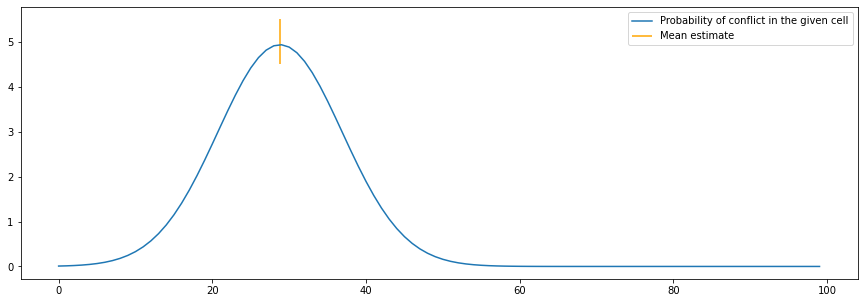

In [295]:
some_cell_mean = grid[(grid['xcoord'] == 25.25) & (grid['ycoord'] == 39.75)]['ensample_mean_t1']
some_cell_std = grid[(grid['xcoord'] == 25.25) & (grid['ycoord'] == 39.75)]['ensample_std_t1']
x = np.arange(0,1,0.01)

ap_norm = scipy.stats.norm.pdf(x, loc=some_cell_mean, scale=some_cell_std)
plt.figure(figsize = [15,5])

plt.vlines(some_cell_mean*100, 4.5,5.5, color = 'orange', label = 'Mean estimate')
plt.plot(ap_norm, label = 'Probability of conflict in the given cell')
plt.legend()
plt.show()

Actully we have the actual predictions in df_hp2, so we don't need to assume normality - we can plot the actual prediction if we want to:

In [322]:
some_grid_predictions = []

for i in range(hp_df2.shape[0]):
    
    mask = (grid['xcoord'] == 25.25) & (grid['ycoord'] == 39.75)
    
    some_grid_predictions.append(hp_df2['preds'][i][mask][0])
    

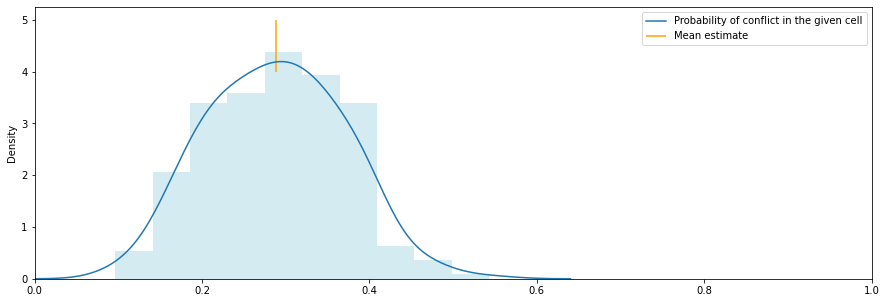

In [349]:
plt.figure(figsize = [15,5])

sns.kdeplot(some_grid_predictions, bw_method= 0.4, label = 'Probability of conflict in the given cell')
plt.hist(some_grid_predictions, density=True, alpha = 0.5, color = 'lightblue')

plt.vlines(some_cell_mean, 4,5, color = 'orange', label = 'Mean estimate')

plt.xlim(0,1)
plt.legend()
plt.show()

Say we want to know the porbability that the probability of conflict is above 22%:

In [346]:
(np.array(some_grid_predictions) > 0.22).sum() / np.array(some_grid_predictions).shape[0]

0.772

So we are 77.2% sure - given our model - that the probability of conflcit in the given cell is above 22%.

We can also get e credibility intaval:

In [347]:
((np.array(some_grid_predictions) >= 0.10) & (np.array(some_grid_predictions) <= 0.40)).sum() / np.array(some_grid_predictions).shape[0]

0.924

So we are 92.4% sure that the probability of conflcit in the given cell is between 10 and 40%. Or we know we want the 95% credibilty interval:

In [366]:
low025 = np.percentile(np.array(some_grid_predictions), 2.5)
low975 = np.percentile(np.array(some_grid_predictions), 97.5)

In [369]:
print(low025, low975)

0.14523508846759797 0.4403474397957325


So, we are 95% the probability of conflict is between 14.5 and 44% - given our specific model and date. Lest plot for jazz: 

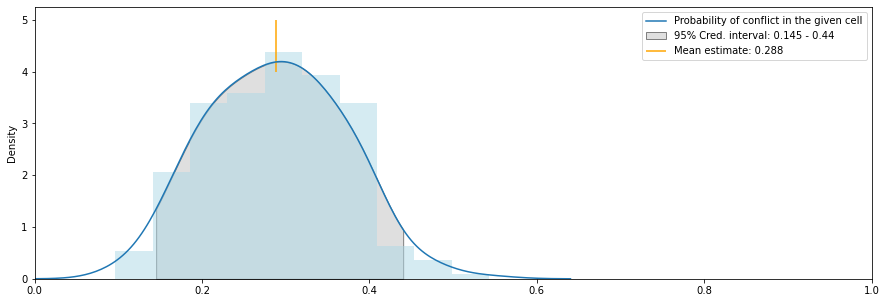

In [380]:
plt.figure(figsize = [15,5])

sns.kdeplot(some_grid_predictions, bw_method= 0.4, label = 'Probability of conflict in the given cell')
sns.kdeplot(some_grid_predictions, bw_method= 0.4, fill = True , clip = (low975,low025), color = 'gray', label = f'95% Cred. interval: {low025:.3} - {low975:.3}')

plt.hist(some_grid_predictions, density=True, alpha = 0.5, color = 'lightblue')

plt.vlines(some_cell_mean, 4,5, color = 'orange', label = f'Mean estimate: {some_cell_mean.iloc[0]:.3}')

plt.xlim(0,1)
plt.legend()
plt.show()

Cool.. Lest move on to somehting else. Lets plot the precision-recall curve

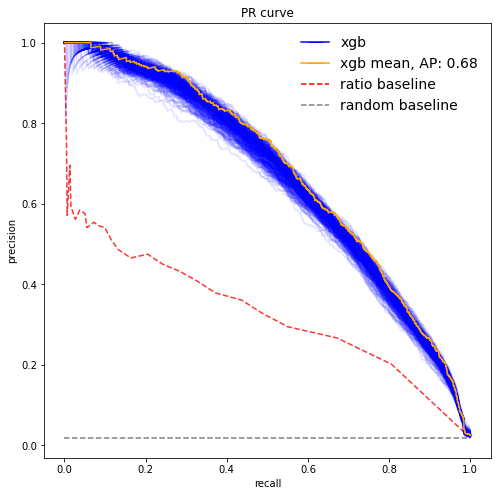

In [238]:
random_base = (y_val['binary_best_t1']>0).mean()
ratio_base_precision, ratio_base_recall, _ = metrics.precision_recall_curve(y_val['binary_best_t1'], X_val['ratio_best']) 
xgb_mean_precision, xgb_mean_recall, _ = metrics.precision_recall_curve(y_val['binary_best_t1'],grid['ensample_mean_t1']) 
xgb_mean_AP = metrics.average_precision_score(y_val['binary_best_t1'], grid['ensample_mean_t1'])


plt.figure(figsize = [8,8])

plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')

plt.plot(ratio_base_recall,ratio_base_precision, '--', color = 'red', alpha = 0.8)
plt.hlines(random_base, 0, 1, linestyles='dashed', color = 'gray')

for i in pr_list: 
    
    plt.plot(i[1], i[0], color = 'blue', alpha = 0.1)
    
plt.plot(xgb_mean_recall,xgb_mean_precision, color = 'orange', alpha = 1)

    
xgb_line = mlines.Line2D([], [], color='blue', marker='_', markersize=15, label='xgb')
xgb_mean_line = mlines.Line2D([], [], color='orange', marker='_', markersize=15, label=f'xgb mean, AP: {xgb_mean_AP:.2}')
random_line = mlines.Line2D([], [], color='gray', linestyle='--', markersize=15, label='random baseline')
ratio_line = mlines.Line2D([], [], color='red', linestyle='--', markersize=15, label='ratio baseline')

plt.legend(handles=[xgb_line, xgb_mean_line, ratio_line, random_line],frameon = False, fontsize = 14)
    

plt.show()

So, we know the distribution is a bit skewed, but I am still surprised to see the mean predictions doing so well. I would check my code a couple of times to be sure this is not caused by some error, but since this is just a notebook for fun and giggles I'll leave it as an exercises for the reader ;) Now lets try to find a suitable threshold for our "confusion map":

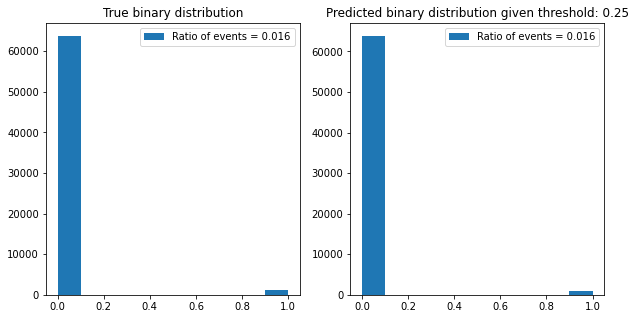

In [247]:
plt.figure(figsize = [10,5])

events_lastY = X_train[X_train['year'] == X_train['year'].max()]['binary_best']

plt.subplot(1,2,1, title = 'True binary distribution')
plt.hist(events_lastY, density = False, label = f'Ratio of events = {events_lastY.mean():.2}')
plt.legend()

threshold = 0.25
events_predicted = (grid['ensample_mean_t1']>=threshold)*1

plt.subplot(1,2,2, title = f'Predicted binary distribution given threshold: {threshold}')
plt.hist(events_predicted, density = False, label = f'Ratio of events = {events_predicted.mean():.2}')
plt.legend()
plt.show()

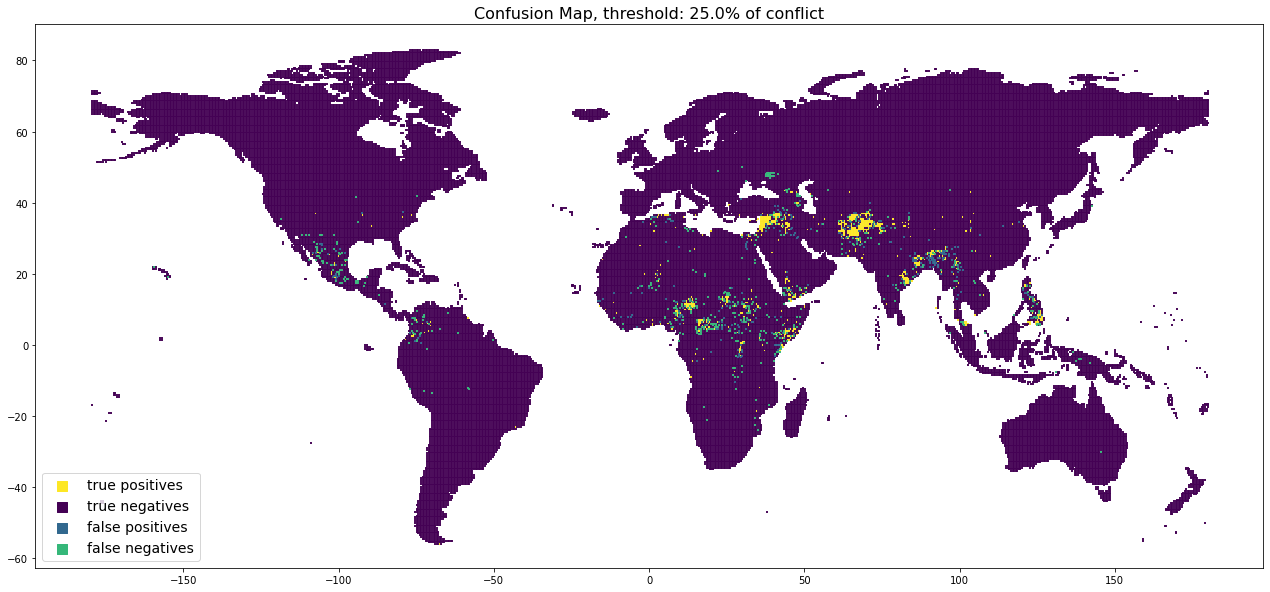

In [248]:
envents_true = y_val['binary_best_t1']

grid['TP_t1'] = ((envents_true.values == 1) & (events_predicted.values == 1))*1
grid['TN_t1'] = (envents_true.values == 0) & (events_predicted.values == 0)*1
grid['FP_t1'] = (envents_true.values == 0) & (events_predicted.values == 1)*1
grid['FN_t1'] = (envents_true.values == 1) & (events_predicted.values == 0)*1


cats_list = ['TP_t1','TN_t1','FP_t1','FN_t1']
labels = ['true positives', 'true negatives', 'false positives', 'false negatives']

viridis = cm.get_cmap('viridis', 4)
colors = [viridis.colors[3],viridis.colors[0],viridis.colors[1],viridis.colors[2]]
# colors = ['steelblue','maroon','lightsteelblue','indianred']


plt.figure(figsize = [22,10])

for i, j in enumerate(cats_list):
    
    sub_set = grid[grid[j] == 1]
    plt.scatter(sub_set['xcoord'], sub_set['ycoord'], color =colors[i], s=1, marker='s',  label = labels[i])
    
plt.title(f'Confusion Map, threshold: {threshold*100}% of conflict', fontsize = 16)
plt.legend(fontsize = 14, markerscale = 10, loc = 3)
plt.show()

Nice